## Exploración para el split de onjutnos de entrenamiento y prueba

El objetivo de este notebook es determinar si se pueden obtener dos conjuntos, el de prueba y entrenamiento tal que haya un documento para cada evaluador en cada conjunto.

In [1]:
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample 

In [2]:
df_proyectos_eval_ = load("../../data/entrenamiento/datos_training_n_eval_5_sample.pkl")
df_proyectos_eval_.head(2)

,CVU,IVIGENCIA,FVIGENCIA,NIVEL,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO
0,83,2008-01-02,2022-12-31 00:00:00,1,619,PROBLEMAS-2015-01,2015,"Energía eólica y solar,uso agrícola,automatiza...",AUTOMATIZACION Y CONTROL,INGENIERÍA ELÉCTRICA,INGENIERÍA Y TECNOLOGÍA,Estación Híbrida de energía eólica y solar par...,titul propuest estacion hibr energi eolic sol ...
1,83,2008-01-02,2022-12-31 00:00:00,1,1779,PROBLEMAS-2015-01,2015,"celda de combustible regenerativa,celdas solar...",GENERACION,INGENIERÍA ELÉCTRICA,INGENIERÍA Y TECNOLOGÍA,Implementación de sistemas híbridos celdas sol...,implementacion sistem hibr celd solaresccru si...


In [3]:
df_proyectos_eval_.dtypes

CVU                      int64
IVIGENCIA               object
FVIGENCIA               object
NIVEL                    int64
ID_PROYECTO              int64
NUMERO_CONVOCATORIA     object
ANIO                     int64
PALABRAS_CLAVE          object
SUBDISCIPLINA           object
DISCIPLINA              object
AREA                    object
TITULO                  object
DESCRIPCION_PROYECTO    object
dtype: object

nos quedamos unicamente con CVU y Id_proyecto:

In [4]:
df_proyectos_eval_ = df_proyectos_eval_[["CVU", "ID_PROYECTO", "DESCRIPCION_PROYECTO"]]
df_proyectos_eval_.head(10)

,CVU,ID_PROYECTO,DESCRIPCION_PROYECTO
0,83,619,titul propuest estacion hibr energi eolic sol ...
1,83,1779,implementacion sistem hibr celd solaresccru si...
2,83,109898,component critic turbin alab aspas estan somet...
3,83,112657,trav are innovacion desarroll tecnolog magneko...
4,83,112671,contact merc neces client adem vision futur em...
5,160807,619,titul propuest estacion hibr energi eolic sol ...
6,160807,221655,tecnologi disen fabricacion biosensor experime...
7,160807,206007,fortalec infraestructur cuerp academ consolid ...
8,160807,220304,proyect enfoc desarroll celd solar flexibl ada...
9,160807,239590,final proyect obtencion recubr pelicul delg na...


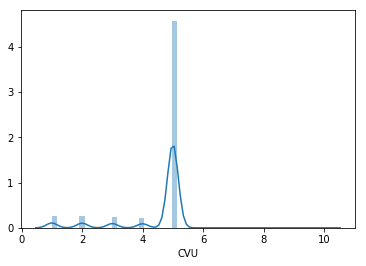

In [5]:
sns.distplot(df_proyectos_eval_['CVU'].value_counts())

In [6]:
pd.DataFrame(df_proyectos_eval_['CVU'].value_counts())["CVU"].value_counts()

5     7285
1      424
2      407
3      372
4      353
10       1
Name: CVU, dtype: int64

---

Se pueden obtener dos conjuntos, el de prueba y entrenamiento tal que haya un documento para cada evaluador en cada conjunto.

Hagamos el split de la siguiente manera:

- En el conjunto test nos quedaremos con un solo texto por evaluador.
- En el conjunto train nos quedaremos con 3 textos por evaluador. El texto de test no debe de encontrarse en este conjunto.


In [7]:
df_proyectos_eval_ = load("../../data/entrenamiento/datos_training_n_eval_5_sample.pkl")

In [8]:
conjunto = "train"
threshold_frecuencia_eval = 3
porcentaje_muestra = .01

In [9]:
def unir_dataframes(df_list):
    """
    Une una lista de dataframes en uno solo.


    Parameters:
    -----------
    df_list: list
            lista donde cada entrada es un DF.

    Returns:
    --------
    df_ dataframe
        dataframe del resultado de la union.
    """
    df = df_list[0].append(df_list[1])
    for i in range(2,len(df_list)):
        df = df.append(df_list[i].reset_index(drop=True))
    df.reset_index(inplace=True, drop=True)
    return df

In [10]:
def split_train_test(df, threshold_frecuencia_eval, porcentaje_muestra):
    """
    Divide el conjunto de datos de los proyectos en dos, uno de prueba y otro de entrenamiento.
    en el conjunto de prueba se almacena un proyecto por evaluador, en el de entrenamiento se
    almacenan hasta 5 textos por evaluador y un minimo de 2.


    Parameters:
    -----------
    df: Dataframe
        datos de los proyectos ya limpios.

    threshold_frecuencia_eval: int
        numero minimo de proyectos por evaluador.
    
    porcentaje_muestra: float
        porcentaje de la muestra del conjunto total de datos.

    Returns:
    --------
    df_test: dataframe
        dataframe de prueba con un texto por evaluador.
        
    df_train: dataframe
        dataframe de prueba con un una cantidad de textos definida por 
        threshold_frecuencia_eval por evaluador.
    """

    #  Primero obtengamos la liste de CVU's que se repiten al menos 3 veces:

    frecuencia_cvu = pd.DataFrame(df['CVU'].value_counts())
    lista_cvus = frecuencia_cvu[
                  frecuencia_cvu["CVU"]>= threshold_frecuencia_eval].index.tolist()
    lista_cvus[:5]

    #  Obtenemos una muestra de los evaluadores con el fin de alivianar el proceso de grid search.

    num_evals = len(lista_cvus)
    lista_cvus = sample(lista_cvus, round(num_evals*porcentaje_muestra))

    #  filtramos el df 

    df = df[df["CVU"].isin(lista_cvus)]
    
    #  dividimos el df en train, test
    lista_coincidencia_cvu_train = []
    lista_coincidencia_cvu_test = []
    for CVU in lista_cvus:
        coincidencia_cvu_train = df[df["CVU"]==CVU].tail(-1)
        coincidencia_cvu_test = df[df["CVU"]==CVU].head(1)
        # guardamos cada df en una lista
        lista_coincidencia_cvu_train.append(coincidencia_cvu_train)
        lista_coincidencia_cvu_test.append(coincidencia_cvu_test)
        
    # juntamos los dataframes en uno:
    df_train = unir_dataframes(df_list=lista_coincidencia_cvu_train)
    df_test = unir_dataframes(df_list=lista_coincidencia_cvu_test)
    
    return df_train, df_test

In [11]:
df_train, df_test = split_train_test(df=df_proyectos_eval_, threshold_frecuencia_eval=3,
                                     thresh_max_frecuencia_eval = 2, porcentaje_muestra=0.1)

TypeError: split_train_test() got an unexpected keyword argument 'thresh_max_frecuencia_eval'

In [ ]:
La funcion se empaqueta en 

In [12]:
df_train.head(10)

,CVU,IVIGENCIA,FVIGENCIA,NIVEL,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO
0,121667,2019-01-01,2023-12-31 00:00:00,3,182934,S0008,2000,None,None,None,None,None,introduccion mexic cuent ampli experient inves...
1,121667,2019-01-01,2023-12-31 00:00:00,3,272890,S0008,2000,None,None,None,None,None,osteoartritis enfermed prevalent enfermedad re...
2,121667,2019-01-01,2023-12-31 00:00:00,3,206404,I0015,2000,None,None,None,None,None,fortalec infraestructur microscopi fluorescent...
3,121667,2019-01-01,2023-12-31 00:00:00,3,188243,I0015,2000,None,None,None,None,None,genet molecul central vari disciplin biolog ap...
4,4435,2016-01-01,2019-12-31 00:00:00,1,179546,I0017,2000,None,None,None,None,None,entend funcion ecosistem marin necesari conoc ...
5,4435,2016-01-01,2019-12-31 00:00:00,1,179753,I0017,2000,None,None,None,None,None,antecedent inter cicl carbon marin increment u...
6,4435,2016-01-01,2019-12-31 00:00:00,1,37567,M0034,2000,None,None,None,None,None,estudi plante aproximacion multipl trazador mo...
7,4435,2016-01-01,2019-12-31 00:00:00,1,23801,S0010,2000,None,None,None,None,None,propuest part proyect larg alcanc centr cienci...
8,21901,2015-01-01,2019-12-31 00:00:00,2,161898,I0010,2000,None,None,None,None,None,pes grand avanc cienci ultim cinc dec exist to...
9,21901,2015-01-01,2019-12-31 00:00:00,2,84774,I0003,2000,None,None,None,None,None,proyect plante analiz papel jug organ oper mun...


In [13]:
df_test

,CVU,IVIGENCIA,FVIGENCIA,NIVEL,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,PALABRAS_CLAVE,SUBDISCIPLINA,DISCIPLINA,AREA,TITULO,DESCRIPCION_PROYECTO
0,121667,2019-01-01,2023-12-31 00:00:00,3,272707,S0008,2000,None,None,None,None,None,actual osteoporosis caus millon fractur anual ...
1,4435,2016-01-01,2019-12-31 00:00:00,1,169543,I0017,2000,None,None,None,None,None,inter cicl carbon marin increment ultim deb pr...
2,21901,2015-01-01,2019-12-31 00:00:00,2,258991,I0017,2000,None,None,None,None,None,are urban estan expand ritm rap mund tare admi...
3,836,2010-01-02,2024-12-30 00:00:00,2,133531,I0003,2000,None,None,None,None,None,cuand seleccion sexual postcopul estudi desd v...
4,90554,2019-01-01,2023-12-31 00:00:00,2,151473,C0003,2000,None,None,None,None,None,investigacion prueb validacion proces fabricac...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,122734,2016-01-01,2019-12-31 00:00:00,1,244682,C0009,2000,None,None,None,None,None,grup textil coh empres desd posicion sector te...
797,30654,2018-01-01,2021-12-31 00:00:00,2,257821,I0017,2000,None,None,None,None,None,histor mineri pilar crecimient econom pais reg...
798,122728,2018-01-01,2022-12-31 00:00:00,2,117956,I0010,2000,None,None,None,None,None,sincer pobr result luch contr corrupcion deb b...
799,4138,2006-01-02,2020-12-30 00:00:00,2,60267,I0002,2000,None,None,None,None,None,cosider activ organ respect objet event otros ...
